# Seed Clusters and Instance Tracking Demo

This notebook demonstrates how to use seed clusters to guide tracking of clusters, and demonstrates how to use a clustom clustering function to use a pre-defined instance segmentation as input to the tracking algorithm.

In [ ]:
from arcos4py.tools import ImageTracker, Linker
from skimage.data import binary_blobs
import numpy as np
import matplotlib.pyplot as plt
from napari import Viewer
from tqdm.auto import tqdm
from skimage.measure import label
from napari_timestamper import render_as_rgb

Provide Initial Seed Image for Tracking

In [2]:
blobs = binary_blobs(length=128, n_dim=3, volume_fraction=0.1, rng=1)

In [4]:
viewer = Viewer()
viewer.add_image(blobs, name='blobs', colormap='gray', contrast_limits=[0, 1])
viewer.add_labels(np.zeros_like(blobs, dtype=int), name='seed_image')

<Labels layer 'seed_image' at 0x28ce0093140>

here we generate a seed image with manually drawn labels to initialize the tracking. Subsequent frames will be tracked based on these initial labels.

Text(0.5, 1.0, 'Seed image')

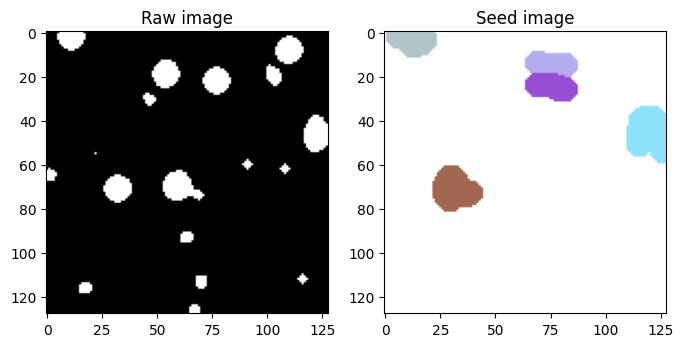

In [37]:
seed_image = viewer.layers['seed_image'].data[0]
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(blobs[0], cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Raw image')
ax[1].imshow(viewer.export_figure(), cmap='nipy_spectral', vmin=0)
ax[1].set_title('Seed image')

In [ ]:
linker = Linker(
    eps=1.5,
    min_clustersize=3,
)
tracker = ImageTracker(linker)
# find index of the time dimension and move it to the front 
out_image = np.zeros_like(blobs, dtype=np.uint16)

tracker.add_seed_image(seed_image)

Overwriting cluster IDs in memory


In [21]:
for i in tqdm(range(blobs.shape[0])):
    out_image[i] = tracker.track_iteration(blobs[i])

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
viewer.add_labels(out_image, name='tracked_instances')

<Labels layer 'tracked_instances' at 0x28ccd6c6b40>

In [ ]:
tracked_rgb = render_as_rgb(viewer, 0)

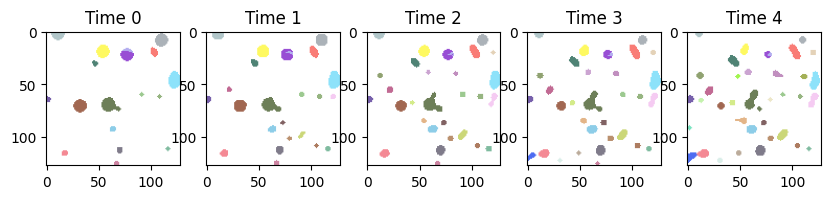

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(tracked_rgb[i])
    ax[i].set_title(f'Time {i}')

Provide instance map instead of clustering using a custom clustering function. 
For illustration purposes we assigned half of the field of view to one cluster and the other half to another cluster.

In [43]:
from arcos4py import track_events_image

In [ ]:
labeled_blobs = np.asarray([label(blobs[i]) for i in range(blobs.shape[0])])
counter = 0 
# blobs: (T, Y, X)
T, Y, X = blobs.shape
mid = X // 2

mask = blobs > 0
right = (np.arange(X) >= mid).reshape(1, 1, X)  # broadcast across T,Y

# make sure it's an integer array (not bool)
labeled_blobs = np.zeros_like(blobs, dtype=np.uint8)

labeled_blobs[mask & right]  = 1
labeled_blobs[mask & ~right] = 2


def custom_clustering(args):
    global counter # use a global counter to keep track of the timepoint, newer version of arcos4py allows passing timepoint as argument
    blobs_timepoint = labeled_blobs[counter]
    flat_blob_instances = blobs_timepoint.flatten()
    active = np.argwhere(flat_blob_instances > 0).flatten()
    counter += 1
    return flat_blob_instances[active]


In [93]:
counter = 0
tracked_events = track_events_image(blobs > 0, eps=1.5, min_clustersize=9, clustering_method=custom_clustering)

100%|██████████| 128/128 [00:00<00:00, 379.64it/s]


In [94]:
viewer = Viewer()
viewer.add_labels(tracked_events, name='tracked_events_custom_clustering')
rgb_blobs_custom_clustering = render_as_rgb(viewer, 0)

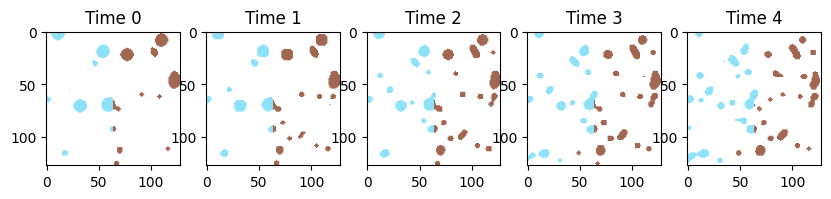

In [95]:
fig, ax = plt.subplots(1,5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(rgb_blobs_custom_clustering[i])
    ax[i].set_title(f'Time {i}')